In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [18]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.inspection import partial_dependence

In [3]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y)

## Individual conditional expectation (ICE)

Narzędzie bedące odpowiednikiem Partial dependency, ale rozważanym dla pojedynczych instancji. Uśredniona wartość ICE to Partial Dependency dla learnera. Narzędzie nadaje się do oceny poszczególnych zmiennych w indywidualncyh przypadkach, jak zmieniła by się predykcja, w przypadku zmiany wartości danej zmiennej. Słabą stroną jest to samo co Partial dependency. Konfiguracje z uśrednionymi wartościami mogą nie wystąpić w zbiorze treningowym.

In [5]:
regp_01 = RF().fit(X, y)

Użyjemy implementacji dostępnej w scikt-learn. Różni się od Pdp tylko parametrem kind="both" (jeżeli chcemy również PDP) lub "individual"

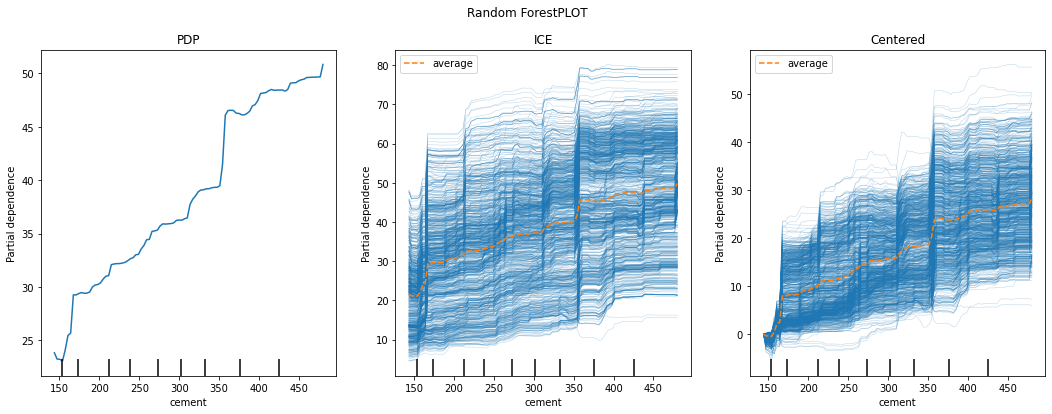

In [17]:
fig, axes = plt.subplots(ncols=3,figsize=(18,6),sharey=True)
PartialDependenceDisplay.from_estimator(regp_01, X, features=["cement"],ax=axes[0])
PartialDependenceDisplay.from_estimator(regp_01, X, features=["cement"],ax=axes[1],kind='both')
PartialDependenceDisplay.from_estimator(regp_01, X, features=["cement"],ax=axes[2],kind='both',centered=True)
_= axes[0].set_title("PDP")
_= axes[1].set_title("ICE")
_= axes[2].set_title("Centered")
_= fig.suptitle("Random Forest")


Podobnie jak w przypadku partial dependence dane znajdują się w słowniku:
pdp['average'][0] - wartość uśredniona (PDP Plot)
pdp['individual'][0][0..n] - wartości zależności poszczególnych zmiennych
pdp['values'] - wartości oryginalnej zmiennej

In [19]:
pdp = partial_dependence(regp_01,X,features=["cement"],kind='both')

ICE plots nadają się do porównań wybranych instancji i testowania scenariuszy `what-if`.

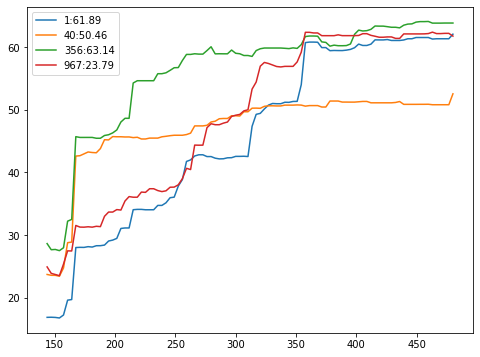

In [45]:
fig, ax = plt.subplots(ncols=1,figsize=(8,6),sharey=True)
for i in (1,40,356,967):
    ax.plot(pdp['values'][0],pdp['individual'][0][i],label="{}:{:.2f}".format(i,y[i]))
ax.legend()

# alternatywnie, selekcja pewnej wartości
#_ = ax.plot(pdp['values'][0],pdp['individual'][0][y<5].T)

**Przykład**: zastosowania do indywidualnych przypadków obarczonych dużym błędem

Sprawdzimy dlaczego wybrane instancje ze zbioru testowego znacząco zawyżają wynik (o 20 i więcej)

In [47]:
regp_02 = RF().fit(X_train, y_train)
yhat = regp_02.predict(X_test)
error = y_test-yhat
error.max()

27.757549999999966

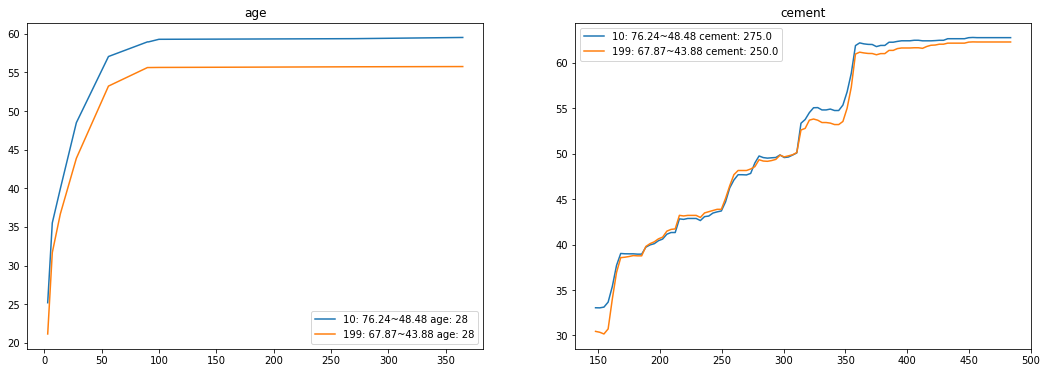

In [89]:

v1='age'
v2='cement'
pdp_v1 = partial_dependence(regp_02,X_test,features=[v1],kind='both')
pdp_v2 = partial_dependence(regp_02,X_test,features=[v2],kind='both')

fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
for i in np.where(error>20)[0]:
    label='{}: {:.2f}~{:.2f} {}: {}'.format(i,y_test.values[i],yhat[i],v1,X_test[v1].values[i])
    _= ax1.plot(pdp_v1['values'][0],pdp_v1['individual'][0][i],label=label)
    label='{}: {:.2f}~{:.2f} {}: {}'.format(i,y_test.values[i],yhat[i],v2,X_test[v2].values[i])
    _= ax2.plot(pdp_v2['values'][0],pdp_v2['individual'][0][i],label=label)
    _= ax1.set_title(v1)
    _= ax2.set_title(v2)
_= ax1.legend()
_= ax2.legend()


## Local interpretable model-agnostic explanations (LIME)

Modele zastępcze, albo surogatowe. Modele typu białej skrzynki używane do przybliżenia modelu czarnej skrzynki. Modele dopasowywane lokalnie dla pojedynczej zmiennej na podstawie losowo zmodyfikowanych zmiennych z najbliższego otoczenia.

Procedura obejmuje:
1. Wybór instancji do wyjaśnienia
2. Losową modyfikację zmiennych pozostałych instancji w otoczeniu badanej instancji
3. Trening modelu black-box, aby uzyskać wartości zmiennych zależnych dla nowych instancji
4. Trening ważonego modelu .fit(X,y,sample_weight) dla nowych instancji i ich predykcji. Sample weight to podobieństwo do badanej instnacji (odległość euklidesowa)
5. WYjaśnienie predykcji poprzez interpretację modelu lokalnego

In [92]:
from lime.lime_tabular import LimeTabularExplainer

In [106]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y)
regp_01 = RF().fit(X.values, y) # aby wyciszyć warningi o braku feature names

In [94]:
X.columns.tolist()

['cement',
 'slag',
 'flyash',
 'water',
 'superplasticizer',
 'coarseaggregate',
 'fineaggregate',
 'age']

In [107]:
explainer = LimeTabularExplainer(X.values,feature_names=X.columns, class_names=['strength'], 
                      discretize_continuous=False,verbose=True,mode='regression')

#UWAGA musi być X.values!

Określenie wskaźników i szybki podgląd:

In [115]:
exp = explainer.explain_instance(X_test.values[1], regp_01.predict, num_samples=100,num_features=8)

Intercept 37.894326913522235
Prediction_local [50.89616426]
Right: 56.41139999999998


In [120]:
#exp.show_in_notebook()
exp.as_list()

[('age', 10.741413277296566),
 ('cement', 7.338444968685206),
 ('slag', 2.498775684652388),
 ('fineaggregate', -2.225597393637825),
 ('water', -1.861263612124104),
 ('superplasticizer', 1.1668497575308934),
 ('flyash', 0.9491610681856569),
 ('coarseaggregate', -0.42034688325864633)]

In [ ]:
output = pd.DataFrame()
for i in range(1030):
    explanation = explainer.explain_instance(X.values[i], regp_01.predict)
    df_dictionary = pd.DataFrame([dict(explanation.as_list())])
    output = pd.concat([output, df_dictionary], ignore_index=True)

In [122]:
output

,age,cement,water,superplasticizer,slag,fineaggregate,flyash,coarseaggregate
0,12.426248,6.461734,-3.721064,2.451029,2.360676,-1.361000,-0.634579,-0.336846
1,12.468396,6.389967,-3.623547,2.197735,2.178890,-1.079129,-0.362822,-0.452157
2,6.874318,6.476708,-3.531696,2.871061,2.985602,-1.176679,-0.183167,-0.329183
3,4.210370,6.348193,-3.681613,2.941662,2.698487,-0.856581,-0.113931,-0.634807
4,5.106081,7.093901,-3.729253,3.259308,3.201761,-1.840671,-0.033729,-0.347266
...,...,...,...,...,...,...,...,...
1025,12.297169,6.850777,-3.143543,2.772385,2.569321,-1.226592,-0.398752,-0.120063
1026,11.805059,6.463252,-3.104484,2.782696,2.263450,-1.514550,-0.395104,-0.177933
1027,11.986930,6.796620,-2.973122,2.734666,2.582186,-1.502444,-0.173085,-0.363872
1028,12.244798,7.004100,-3.123987,2.979082,2.610833,-1.128587,-0.307491,-0.164188


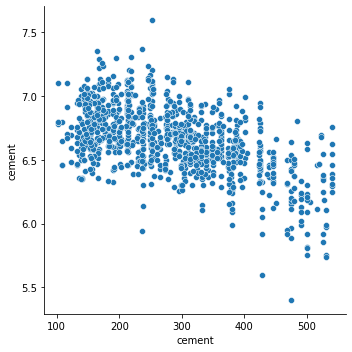

In [126]:
sns.relplot(x=X.cement,y=output.cement)

### Dane Dane kategoryzowane

In [129]:
from sklearn.neighbors import KNeighborsClassifier as KNN

data = pd.read_csv("Datasets/diabetes_class.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [128]:
data

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,positive
1,1,85,66,29,0,26.6,0.351,31,negative
2,8,183,64,0,0,23.3,0.672,32,positive
3,1,89,66,23,94,28.1,0.167,21,negative
4,0,137,40,35,168,43.1,2.288,33,positive
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,negative
764,2,122,70,27,0,36.8,0.340,27,negative
765,5,121,72,23,112,26.2,0.245,30,negative
766,1,126,60,0,0,30.1,0.349,47,positive


In [142]:
cls_01 = KNN().fit(X.values,y)
explainer = LimeTabularExplainer(X.values, feature_names=X.columns, class_names=["negative","positive"], discretize_continuous=True,discretizer='decile')

In [143]:
exp = explainer.explain_instance(X.values[1], cls_01.predict_proba, num_samples=1000,num_features=8)

In [147]:
exp.score

0.09269458106735351

In [144]:
exp.show_in_notebook()

In [145]:
exp.as_list()

[('Plasma glucose concentration <= 85.00', -0.2611894239029913),
 ('2-Hour serum insulin <= 0.00', 0.07299837441429241),
 ('27.00 < Triceps skin fold thickness <= 31.00', 0.029397439379510178),
 ('0.00 < Number of times pregnant <= 1.00', 0.026032812332511198),
 ('0.30 < Diabetes pedigree function <= 0.37', 0.019721613568177445),
 ('29.00 < Age <= 33.00', 0.01603734415413984),
 ('25.90 < Body mass index <= 28.20', 0.007208626284256445),
 ('64.00 < Diastolic blood pressure <= 68.00', 0.0004425987046837472)]